In [1]:
import sys
sys.executable

'/media/HHD_2TB/baurai/aditya_vm/bin/python3.6'

In [32]:
import os
import glob
import shutil
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import  confusion_matrix, f1_score, precision_score, recall_score, classification_report
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Python used = ", sys.version)
print("Tensorflow used = ", tf.__version__)

Python used =  3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
Tensorflow used =  2.3.1


# Dataset : 

NIH Dataset images available at : "/media/HHD2/NIH/tflow_obj_detection/images"

Metadata for NIH is available at : "/media/HHD2/NIH/tflow_obj_detection/data/Data_Entry_2017_v2020.csv"

FILTERED_METADATA_PATH_NIH : contains the OG csv where nodule cases are marked as 1, and healthy as 0.

In [3]:
DATASET_PATH_NIH = "/media/HHD2/NIH/tflow_obj_detection/images/"
METADATA_PATH_NIH = "/media/HHD2/NIH/tflow_obj_detection/data/Data_Entry_2017_v2020.csv"
FILTERED_METADATA_PATH_NIH = "/media/HHD_2TB/baurai/filtered_metadata/metadata.csv"

In [4]:
df = pd.DataFrame(pd.read_csv(FILTERED_METADATA_PATH_NIH))

print(f"Shape of the dataframe = {df.shape}")

Shape of the dataframe = (66692, 5)


In [5]:
df.head()

,image_id,label,patient_id,age,gender
0,00000002_000.png,0,2,80,M
1,00000004_000.png,1,4,82,M
2,00000005_000.png,0,5,69,F
3,00000005_001.png,0,5,69,F
4,00000005_002.png,0,5,69,F


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66692 entries, 0 to 66691
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    66692 non-null  object
 1   label       66692 non-null  int64 
 2   patient_id  66692 non-null  int64 
 3   age         66692 non-null  int64 
 4   gender      66692 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.5+ MB


# Mandatory Helper Functions

In [7]:
def build_decoder(with_labels = True, target_size = (224, 224), ext = "jpg") : 
    def decode(path) : 
        file_bytes = tf.io.read_file(path)
        if ext == "jpg" or ext == "jpeg" : 
            image = tf.image.decode_jpeg(file_bytes, channels = 3)
        elif ext == "png" : 
            image = tf.image.decode_png(file_bytes, channels = 3)
        else:
            raise ValueError("Image extension not supported.")
        
        image = tf.cast(image, tf.float32)/255.0
        image = tf.image.resize(image, target_size)
        return image
    
    def decode_with_labels(path, label) : 
        decoded_image, label = decode(path), label
        return decoded_image, label
    
    
    if with_labels == True : 
        return decode_with_labels
    else:
        return decode

In [8]:
def build_augmenter(with_labels = True) : 
    def augment(image) : 
        image = tf.image.random_flip_left_right(image)
        return image
    
    def augment_with_labels(image, label) : 
        augmented_image, label = augment(image), label
        return augmented_image, label
    
    if with_labels == True : 
        return augment_with_labels
    else:
        return augment

In [9]:
def build_dataset(paths, labels = None, decode_function = None, augment = True, augmenter_function = None, 
                  cache_dir = "", cache = True, shuffle = 1024, repeat = True, batch_size = 16) :
    if cache_dir != "" and cache == True : 
        os.makedirs(cache_dir, exist_ok = True)
    
    if decode_function is None : 
        decode_function = build_decoder(labels is not None)
    
    if augmenter_function is None : 
        augmenter_function = build_augmenter(labels is not None)
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    slices = None
    if len(labels) != 0 : 
        slices = (paths, labels)
    else:
        slices = paths
    
    dataset = tf.data.Dataset.from_tensor_slices(slices)
    dataset = dataset.map(decode_function, num_parallel_calls = AUTOTUNE)
    if cache == True : 
        dataset = dataset.cache(cache_dir)
    if augment == True : 
        dataset = dataset.map(augmenter_function, num_parallel_calls = AUTOTUNE)
    if repeat == True : 
        dataset = dataset.repeat()
    if shuffle : 
        dataset = dataset.shuffle(shuffle)
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    
    #print(list(dataset.as_numpy_iterator()))
    return dataset

# Stratified Sampling

In [10]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_index, val_cum_test_index in split.split(df, df["label"]) : 
    stratified_train_set = df.loc[train_index]
    stratified_val_set = df.loc[val_cum_test_index]

stratified_train_set.reset_index(drop = True, inplace = True)
stratified_val_set.reset_index(drop = True, inplace = True)

In [11]:
print("Size of Stratified Training set = ", stratified_train_set.shape)
stratified_train_set.head()

Size of Stratified Training set =  (46684, 5)


,image_id,label,patient_id,age,gender
0,00012907_003.png,0,12907,40,M
1,00014264_002.png,0,14264,64,M
2,00001650_007.png,0,1650,62,M
3,00013894_000.png,1,13894,19,M
4,00017707_001.png,0,17707,25,M


In [12]:
print("Size of Stratified Validation set = ", stratified_val_set.shape)
stratified_val_set.head()

Size of Stratified Validation set =  (20008, 5)


,image_id,label,patient_id,age,gender
0,00002524_003.png,0,2524,62,M
1,00001023_002.png,0,1023,51,F
2,00015779_000.png,0,15779,34,F
3,00012051_005.png,0,12051,10,F
4,00020325_000.png,0,20325,53,F


# Analyze Distribution : 

In [13]:
def analyze_label_distribution(dataframe, case = "train") : 
    """
    Training and validationframes are passed to this method.
    """
    label_count = dict()
    for label in tqdm(dataframe["label"].values) : 
        if label not in label_count : 
            label_count[label] = 1
        else:
            label_count[label] += 1
    labels = ["Healthy Cases", "Nodular Cases"]
    counts = [label_count[0], label_count[1]]
    explode = (0.05, 0.05)
    
    plt.figure(figsize = (12, 8))
    plt.pie(counts, explode = explode, labels = labels, shadow = True, startangle = 90)
    plt.axis("equal")
    
    print("Healthy cases count = ", label_count[0])
    print("Nodular cases count = ", label_count[1])

  0%|          | 0/46684 [00:00<?, ?it/s]

Healthy cases count =  42252
Nodular cases count =  4432


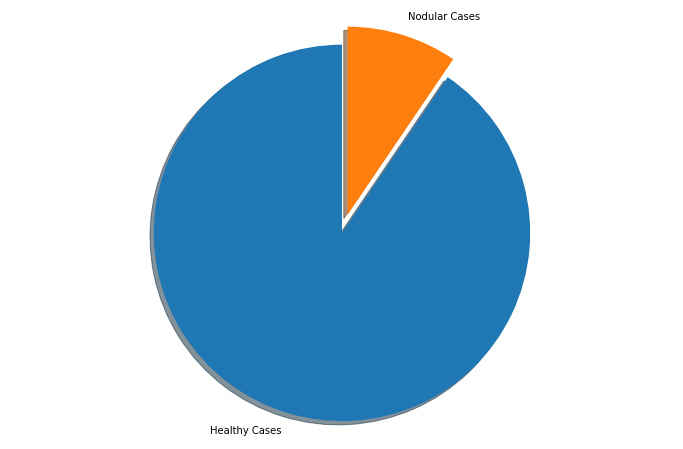

In [14]:
analyze_label_distribution(stratified_train_set)

  0%|          | 0/20008 [00:00<?, ?it/s]

Healthy cases count =  18109
Nodular cases count =  1899


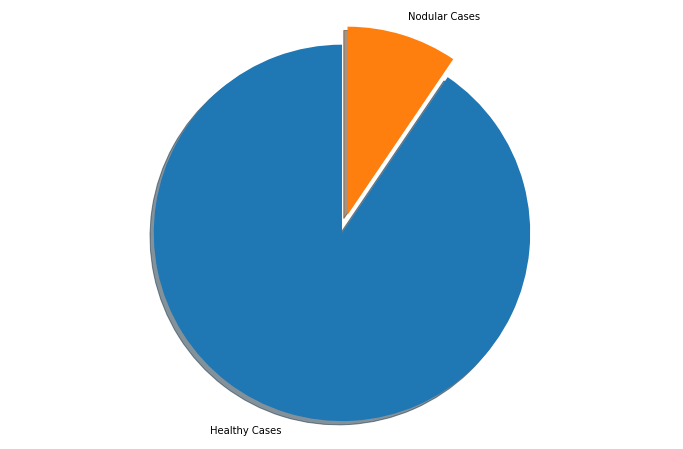

In [15]:
analyze_label_distribution(stratified_val_set)

# Prepare Datasets & Prepare Config File

In [16]:
config = {
    "IMAGE_SIZE" : (224, 224),
    "BATCH_SIZE" : 16,
    "DATASET_PATH_NIH" : "/media/HHD2/NIH/tflow_obj_detection/images/",
    "CACHE_DIR" : "/media/HHD_2TB/baurai/tf_cache/cache"
}

if os.path.exists(config["CACHE_DIR"]) : 
    shutil.rmtree(config["CACHE_DIR"])
os.mkdir(config["CACHE_DIR"])

In [17]:
decoder = build_decoder(with_labels = True, target_size = config["IMAGE_SIZE"])
decoder

<function __main__.build_decoder.<locals>.decode_with_labels(path, label)>

In [18]:
all_train_ids = stratified_train_set.image_id.values

train_paths = []
for train_id in tqdm(all_train_ids) : 
    image_path = config["DATASET_PATH_NIH"] + train_id
    train_paths.append(image_path)
    
train_labels = stratified_train_set.label.values
dataset_train = build_dataset(paths = train_paths, labels = train_labels, batch_size = config["BATCH_SIZE"], decode_function = decoder,
                             cache_dir = config["CACHE_DIR"])
dataset_train

  0%|          | 0/46684 [00:00<?, ?it/s]

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [19]:
all_val_ids = stratified_val_set.image_id.values

val_paths = []
for val_id in tqdm(all_val_ids) : 
    image_path = config["DATASET_PATH_NIH"] + val_id
    val_paths.append(image_path)
    
val_labels = stratified_val_set.label.values
dataset_val = build_dataset(paths = val_paths, labels = val_labels, batch_size = config["BATCH_SIZE"], decode_function = decoder,
                           augment = False, shuffle = False, repeat = False, cache_dir = config["CACHE_DIR"])
dataset_val

  0%|          | 0/20008 [00:00<?, ?it/s]

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

Take some items and visualize.

In [20]:
"""
data, _ = dataset_train.take(2)
images = data[0].numpy()

plt.figure(figsize = (20, 12))
plt.title("Training Batch Visualized", fontsize = 19)
for i in range(config["BATCH_SIZE"]) :
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.grid(False)
    plt.axis("off")
plt.tight_layout()
"""

# Construct CheXNet

In [22]:
config

{'IMAGE_SIZE': (224, 224),
 'BATCH_SIZE': 16,
 'DATASET_PATH_NIH': '/media/HHD2/NIH/tflow_obj_detection/images/',
 'CACHE_DIR': '/media/HHD_2TB/baurai/tf_cache/cache'}

Add STEPS PER EPOCH TRAIN & VAL to the config.

In [28]:
steps_per_epoch_train = len(train_paths) // config["BATCH_SIZE"]
steps_per_epoch_val = len(val_paths) // config["BATCH_SIZE"]

print(f"Steps per epoch / Train = {steps_per_epoch_train}")
print(f"Steps per epoch / Val = {steps_per_epoch_val}")

# add to config
config["STEPS_PER_EPOCH_TRAIN"] = steps_per_epoch_train
config["STEPS_PER_EPOCH_VAL"] = steps_per_epoch_val
config

Steps per epoch / Train = 2917
Steps per epoch / Val = 1250


{'IMAGE_SIZE': (224, 224),
 'BATCH_SIZE': 16,
 'DATASET_PATH_NIH': '/media/HHD2/NIH/tflow_obj_detection/images/',
 'CACHE_DIR': '/media/HHD_2TB/baurai/tf_cache/cache',
 'STEPS_PER_EPOCH_TRAIN': 2917,
 'STEPS_PER_EPOCH_VAL': 1250}

## Define Callbacks

In [35]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_chexnet_model.h5", save_best_only = True, monitor = "val_auc", mode = "max")
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, monitor = "val_auc", mode = "max")
lr_reducer_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_auc", patience = 5, min_lr = 1e-7, mode = "max")

# defining tensorboard callback
root_logdir = os.path.join(os.curdir, "my_logs")
if os.path.exists(root_logdir) : 
    shutil.rmtree(root_logdir)
os.mkdir(root_logdir)

def get_run_logdir() : 
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir =  get_run_logdir() 

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [36]:
with tf.device("/device:GPU:0"):
    base_model = tf.keras.applications.DenseNet121(weights = "imagenet", include_top = False, 
                                                   input_shape = (config["IMAGE_SIZE"][0], config["IMAGE_SIZE"][1], 3))
    global_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    dropout_1 = tf.keras.layers.Dropout(0.5)(global_pooling)
    output = tf.keras.layers.Dense(units = 1, activation = "sigmoid", name = "predictions")(dropout_1)
    
    model = tf.keras.Model(base_model.input, output)
    model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = [tf.keras.metrics.AUC(multi_label = False)])
    model.summary()
    
    # visualize
    plot_model(model, to_file = "./models_visuals/my_chexnet_model_plot.png", show_shapes = True, show_layer_names = True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
tf.keras.backend.clear_session()

with tf.device("/device:GPU:0") :
    history = model.fit(dataset_train, steps_per_epoch = config["STEPS_PER_EPOCH_TRAIN"],
                        dataset_val, validation_steps = config["STEPS_PER_EPOCH_VAL"],
                        epochs = config["EPOCHS"], verbose = 1,
                        callbacks = [checkpoint_cb, early_stopping_cb, lr_reducer_cb, tensorboard_cb]
                       )

In [ ]:
# visualize learning. Can go for TensorBoard too.
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Confusion Matrix

In [ ]:
with tf.device("/device:GPU:0") :
    y_pred = resnet50v2.predict(dataset_val, config["STEPS_PER_EPOCH_VAL"], verbose = True)

In [ ]:
y_true = val.classes
type(y_true)

In [ ]:
predicted_labels = []
for prob in y_pred : 
    if prob >= 0.5 : 
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

In [ ]:
cm = confusion_matrix(y_true, predicted_labels)
print(cm)

plt.figure(figsize = (12, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = "d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 16)
ax.set_ylabel('True labels', fontsize = 16) 
ax.set_title('Confusion Matrix', fontsize = 18) 
ax.xaxis.set_ticklabels(['Healthy', 'Nodular'])
ax.yaxis.set_ticklabels(['Healthy', 'Nodular']);

In [ ]:
f1 = f1_score(y_true, predicted_labels, average = "binary")
precision = precision_score(y_true, predicted_labels, average = "binary")
recall = recall_score(y_true, predicted_labels, average = "binary")
print("f1 score = ", f1)
print("precision = ", precision)
print("Recall = ", recall)

In [ ]:
print(classification_report(y_true, predicted_labels, labels = [0, 1], target_names = ["Healthy", "Nodular"]))

In [ ]:
#model.save('saved_models/my_chexnet_model')